In [54]:
%load_ext autoreload
%autoreload 2

In [92]:
import numpy as np
import pickle
from load_5hot import load
from onehot_tostring import convert_to_nucs, show_noise
from keras import layers
from keras import callbacks
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D, Add, Reshape
from keras.layers import AveragePooling2D, UpSampling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
from keras.layers.core import Lambda
from keras.models import Model
import matplotlib.pyplot as plt
import datetime
from keras.activations import softmax

K.set_image_data_format('channels_last')
print('Done')

Done


In [67]:
[X_train,Y_train,X_test,Y_test,X_val,Y_val] = load("blast_tab_1hit.out")

Loading Data...
101886 sequences were uploaded

Maximum sequence length in is 308
Maximum sequence length out is 308

Converting to one-hot...
Done
Converting to one-hot...
Done
Converting to one-hot...
Done


In [68]:
m = X_train.shape[0]
print("There are " + str(m) + " training examples")
print("There are " + str(X_val.shape[0]) + " validation examples")
print("There are " + str(X_test.shape[0]) + " testing examples")
print("There are " + str(X_train.shape[1]) + " classes: A, C, G, T, -")
max_length = max(X_train.shape[2],X_test.shape[2])
print("The longest sequence is " + str(max_length) + " nucleotides long")
print("X_train shape is:")
print(X_train.shape)

There are 77510 training examples
There are 12269 validation examples
There are 12107 testing examples
There are 5 classes: A, C, G, T, -
The longest sequence is 308 nucleotides long
X_train shape is:
(77510, 5, 308, 1)


In [69]:
# Visualize data sets to ensure they appear as anticipated
def display_example_sequences(X,Y,n):
    for sample in range(n):
        samp_n_X = convert_to_nucs(X[sample,:,:,0])
        samp_n_Y = convert_to_nucs(Y[sample,:,:,0])
        print(samp_n_X + ', ' + samp_n_Y + '\n')

    print('')
    
n_examples = 3
print('\nTraining Examples:\n')
display_example_sequences(X_train,Y_train,n_examples)
print('\nValidation Examples:\n')
display_example_sequences(X_val,Y_val,n_examples)
print('\nTesting Examples:\n')
display_example_sequences(X_test,Y_test,n_examples)


Training Examples:

ACGGAGGGTGCGAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGCTTGGTAAGTCAGGGGTGAAAGCCCGCGGCTCAACCGCGGAATTGCCTTTGATACTGC-CGAGCTAGAGTCCGGGAGAGGGTAGTGGAATTCCAGGTGTAGGAGTGAAATCCGTAGAGATCTGGAGGAACATCAGTGGCGAAGGCGACTACCTGGACCGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG--------------------------------------------------------, ACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGTTATGTAAGTCAGGGGTGAAAGCCCACGGCTCAACCGTGGAACTGCCCTTGATACTGCACGA-CTCGAATCCGGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGGCCACCTGGACCGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG--------------------------------------------------------

ACAGAGGGGGCAAGCGTTGTCCGGAGTTACTGGGCGTAAAGGGCGCGCAGGCGGTGGGCTGCGTCGGCGCTGAAAGCGCCCCGCTTAACGGGGCGAGGCGCGCCGATACGAGTCCACTCGAGGCAAGCAGAGGGTGGCGGAATTCCGGGTGGAGTGGTGAAATGCGTAGAGATCCGGAGGAACGCCGGTGGGGAAGCCGGCCACCTGGGCTTGACCTGACGCTGCGGCGCGACAGCGTGGGGAGCAAACCG---------------------------------------------------------, ACAGAGGGGGCAAGCGTTGTCCGGAGTTACTGGGCGTAAAGGGCGCGCA

In [70]:
print('Permuting training samples...')
np.random.seed(0)
rand_perm = np.random.rand(m).argsort()
np.take(X_train,rand_perm,axis=0,out=X_train)
print("finished X")
np.take(Y_train,rand_perm,axis=0,out=Y_train)
print("finished Y")

Permuting training samples...
finished X
finished Y


In [71]:
ngf = 16
input_nc = 1
output_nc = 1
n_blocks_gen = 9

def softMaxAxis1(x):
    return softmax(x,axis=1)

# started from: https://blog.sicara.com/keras-generative-adversarial-networks-image-deblurring-45e3ab6977b5
def Model_1(input_shape):
    """Build generator architecture."""
    # Current version : ResNet block
    X_input = Input(input_shape)
    
    # X = ZeroPadding2D((0, 3))(X_input) # allows 'valid' in conv0 to keep length and collapse one-hot

    X = Conv2D(128, (4, 7), strides = (1, 1), padding = 'same', name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(64, (1, 7), strides = (1, 1), padding = 'same', name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(64, (1, 7), strides = (1, 1), padding = 'same', name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Dropout(0.3, name = 'dropout')(X)
   
    X = Conv2D(32, (1, 7), strides = (1, 1), padding = 'same', name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(1, (1, 1), strides = (1, 1), padding = 'same', name = 'conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Dense(1, activation = softMaxAxis1)(X)
    
    model = Model(inputs=X_input, outputs=X, name='Model_2')
    return model

In [83]:
myModel = Model_1((5,max_length,1))
print(myModel.summary())
print('Done!')
logging = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 5, 308, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 5, 308, 128)       3712      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 5, 308, 128)       512       
_________________________________________________________________
activation_17 (Activation)   (None, 5, 308, 128)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 5, 308, 64)        57408     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 5, 308, 64)        256       
_________________________________________________________________
activation_18 (Activation)   (None, 5, 308, 64)        0         
__________

In [84]:
myModel.compile(optimizer="Adam", loss="mean_squared_error", metrics = ["accuracy"])
print('Done!')

Done!


In [74]:
# Understand baseline accuracy of if model output its own input
diffs = np.absolute(X_train-Y_train);
err = np.sum(diffs)/np.ma.size(X_train);
print("Baseline accuracy of Train if predicting output = input is " + str(1-err))

diffs = np.absolute(X_val-Y_val);
err = np.sum(diffs)/np.ma.size(X_val);
print("Baseline accuracy of Val if predicting output = input is " + str(1-err))

diffs = np.absolute(X_test-Y_test);
err = np.sum(diffs)/np.ma.size(X_test);
print("Baseline accuracy of Test if predicting output = input is " + str(1-err))

Baseline accuracy of Train if predicting output = input is 0.994588750173836
Baseline accuracy of Val if predicting output = input is 0.999137833394904
Baseline accuracy of Test if predicting output = input is 0.9990534616123119


In [85]:
class NBatchLogger(callbacks.Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.losses = []
        self.accs = []

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        if self.step % self.display == 0:
            loss = logs.get('loss')
            acc = logs.get('acc')
            self.losses.append(loss)
            self.accs.append(acc)
            print('\nstep {}: loss = {}, acc = {}'.format(self.step, loss, acc))

            
out_batch = NBatchLogger(display=100)
history = myModel.fit(x = X_train, y = Y_train, epochs = 8, validation_data = (X_val, Y_val), batch_size = 20, callbacks = [out_batch], verbose = 1)

loss_and_acc = myModel.evaluate(X_test, Y_test)
print(loss_and_acc)

currtime = datetime.datetime.now()
fname = "./convWeights/" + currtime.strftime("%m%d-%H%M") + "_5hot.hdf5"
print(fname)
myModel.save_weights(fname)
logging.append(out_batch)

Train on 77510 samples, validate on 12269 samples
Epoch 1/8
 2000/77510 [..............................] - ETA: 1:06:04 - loss: 0.0372 - acc: 0.9884
step 100: loss = 0.029664497822523117, acc = 0.9922402501106262
 4000/77510 [>.............................] - ETA: 1:02:55 - loss: 0.0302 - acc: 0.9922
step 200: loss = 0.019517946988344193, acc = 0.9968830943107605
 6000/77510 [=>............................] - ETA: 59:34 - loss: 0.0258 - acc: 0.9939
step 300: loss = 0.01615731418132782, acc = 0.9961038827896118
 8000/77510 [==>...........................] - ETA: 57:02 - loss: 0.0227 - acc: 0.9949
step 400: loss = 0.012312302365899086, acc = 0.9983766078948975
10000/77510 [==>...........................] - ETA: 54:58 - loss: 0.0206 - acc: 0.9955
step 500: loss = 0.012428302317857742, acc = 0.9968830943107605
12000/77510 [===>..........................] - ETA: 53:02 - loss: 0.0190 - acc: 0.9959
step 600: loss = 0.011275513097643852, acc = 0.9975324869155884
14000/77510 [====>.............

30480/77510 [==========>...................] - ETA: 38:17 - loss: 0.0089 - acc: 0.9985
step 5400: loss = 0.008534017018973827, acc = 0.9988636374473572
32480/77510 [===========>..................] - ETA: 36:38 - loss: 0.0089 - acc: 0.9985
step 5500: loss = 0.008176573552191257, acc = 0.9991233944892883
34480/77510 [============>.................] - ETA: 35:12 - loss: 0.0089 - acc: 0.9985
step 5600: loss = 0.009493514895439148, acc = 0.9977921843528748
36480/77510 [=============>................] - ETA: 33:46 - loss: 0.0089 - acc: 0.9985
step 5700: loss = 0.009841037914156914, acc = 0.9975000023841858
38480/77510 [=============>................] - ETA: 32:15 - loss: 0.0088 - acc: 0.9985
step 5800: loss = 0.008399231359362602, acc = 0.9990260004997253
40480/77510 [==============>...............] - ETA: 30:39 - loss: 0.0088 - acc: 0.9985
step 5900: loss = 0.00918654352426529, acc = 0.9981493353843689
42480/77510 [===============>..............] - ETA: 29:03 - loss: 0.0088 - acc: 0.9985
st

58960/77510 [=====================>........] - ETA: 15:23 - loss: 0.0087 - acc: 0.9987
step 10700: loss = 0.008849562145769596, acc = 0.9985714554786682
60960/77510 [======================>.......] - ETA: 13:43 - loss: 0.0087 - acc: 0.9987
step 10800: loss = 0.007829698733985424, acc = 0.9995454549789429
62960/77510 [=======================>......] - ETA: 12:04 - loss: 0.0087 - acc: 0.9987
step 10900: loss = 0.007760000415146351, acc = 0.9996103644371033
64960/77510 [========================>.....] - ETA: 10:24 - loss: 0.0087 - acc: 0.9987
step 11000: loss = 0.008059415966272354, acc = 0.9993181824684143
66960/77510 [========================>.....] - ETA: 8:44 - loss: 0.0087 - acc: 0.9987
step 11100: loss = 0.007867627777159214, acc = 0.9994480609893799
68960/77510 [=========================>....] - ETA: 7:05 - loss: 0.0087 - acc: 0.9987
step 11200: loss = 0.007998963817954063, acc = 0.9993506669998169
70960/77510 [==========================>...] - ETA: 5:25 - loss: 0.0087 - acc: 0.998

 7920/77510 [==>...........................] - ETA: 57:08 - loss: 0.0086 - acc: 0.9988
step 15900: loss = 0.008132373914122581, acc = 0.9992856979370117
 9920/77510 [==>...........................] - ETA: 55:28 - loss: 0.0086 - acc: 0.9988
step 16000: loss = 0.008172688074409962, acc = 0.9992207884788513
11920/77510 [===>..........................] - ETA: 53:51 - loss: 0.0086 - acc: 0.9988
step 16100: loss = 0.011481653898954391, acc = 0.9958117008209229
13920/77510 [====>.........................] - ETA: 52:20 - loss: 0.0086 - acc: 0.9988
step 16200: loss = 0.009094232693314552, acc = 0.9982792139053345
15920/77510 [=====>........................] - ETA: 50:43 - loss: 0.0086 - acc: 0.9988
step 16300: loss = 0.009992801584303379, acc = 0.9974026083946228
17920/77510 [=====>........................] - ETA: 48:53 - loss: 0.0086 - acc: 0.9988
step 16400: loss = 0.007783564273267984, acc = 0.9995454549789429
19920/77510 [======>.......................] - ETA: 47:06 - loss: 0.0086 - acc: 0.

36400/77510 [=============>................] - ETA: 32:22 - loss: 0.0085 - acc: 0.9988
step 21200: loss = 0.007702133152633905, acc = 0.9996753334999084
38400/77510 [=============>................] - ETA: 30:48 - loss: 0.0085 - acc: 0.9988
step 21300: loss = 0.008695442229509354, acc = 0.9986363649368286
40400/77510 [==============>...............] - ETA: 29:13 - loss: 0.0085 - acc: 0.9988
step 21400: loss = 0.010515005327761173, acc = 0.9968181848526001
42400/77510 [===============>..............] - ETA: 27:39 - loss: 0.0085 - acc: 0.9988
step 21500: loss = 0.007803717162460089, acc = 0.9996103644371033
44400/77510 [================>.............] - ETA: 26:05 - loss: 0.0085 - acc: 0.9988
step 21600: loss = 0.009633000008761883, acc = 0.9977272748947144
46400/77510 [================>.............] - ETA: 24:30 - loss: 0.0085 - acc: 0.9988
step 21700: loss = 0.008992713876068592, acc = 0.9983441829681396
48400/77510 [=================>............] - ETA: 22:56 - loss: 0.0085 - acc: 0.

64880/77510 [========================>.....] - ETA: 9:56 - loss: 0.0085 - acc: 0.9989
step 26500: loss = 0.0076713040471076965, acc = 0.9996753334999084
66880/77510 [========================>.....] - ETA: 8:22 - loss: 0.0085 - acc: 0.9989
step 26600: loss = 0.010222632437944412, acc = 0.9970129728317261
68880/77510 [=========================>....] - ETA: 6:47 - loss: 0.0085 - acc: 0.9989
step 26700: loss = 0.00790601409971714, acc = 0.9994805455207825
70880/77510 [==========================>...] - ETA: 5:13 - loss: 0.0085 - acc: 0.9989
step 26800: loss = 0.007961941882967949, acc = 0.9994155764579773
72880/77510 [===========================>..] - ETA: 3:38 - loss: 0.0085 - acc: 0.9989
step 26900: loss = 0.008495154790580273, acc = 0.9988961219787598
74880/77510 [===========================>..] - ETA: 2:04 - loss: 0.0085 - acc: 0.9989
step 27000: loss = 0.009760592132806778, acc = 0.9975649118423462
76880/77510 [============================>.] - ETA: 29s - loss: 0.0085 - acc: 0.9989
ste

In [93]:
histfname = "./trainHistoryDict_" + currtime.strftime("%m%d-%H%M") + "_5hot"
with open(histfname, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [95]:
histfname = "./trainHistoryDict_" + "0603-0412" + "_5hot"
history = pickle.load(open(histfname, "rb" ))

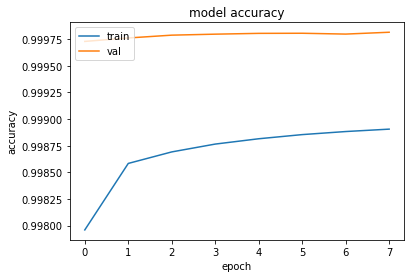

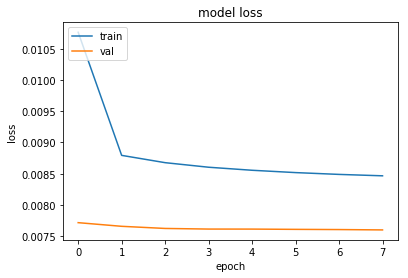

In [96]:
plt.plot(favorite_color['acc'])
plt.plot(favorite_color['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(favorite_color['loss'])
plt.plot(favorite_color['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [96]:
preds = myModel.predict(x = X_test)

In [79]:
# Show whole sequence
for n in range(100):
    print("Sample number " + str(n+1))
    samp_n_pred = preds[n,:,:,0]
    samp_n_in = X_test[n,:,:,0]
    samp_n_true = Y_test[n,:,:,0]

    samp_n_pred = convert_to_nucs(samp_n_pred)
    samp_n_true = convert_to_nucs(samp_n_true)
    samp_n_in = convert_to_nucs(samp_n_in)
    noisy = show_noise(samp_n_pred, samp_n_true, samp_n_in)

    print('Predicted:')
    print('Denoised:')
    print('Noisy:')
    print('Noise locations:\n')

    stt = 0
    stp = 100
    while(stp < len(noisy)):
        print(samp_n_pred[stt:stp])
        print(samp_n_true[stt:stp])
        print(samp_n_in[stt:stp])
        print(noisy[stt:stp])
        print('')
        stt = stp
        stp = stt+100



Sample number 1


NameError: name 'preds' is not defined

In [95]:
myModel.load_weights("./convWeights/0531-2012_5hot.hdf5")